In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.append(os.path.abspath('../'))
sys.argv = ['main.py']
import argparse
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import time
from my_main import *

In [3]:

cmd_opt = argparse.ArgumentParser(description='Argparser for graph_classification')
cmd_opt.add_argument('-mode', default='cpu', help='cpu/gpu')
cmd_opt.add_argument('-gm', default='mean_field', help='mean_field/loopy_bp')
cmd_opt.add_argument('-data', default=None, help='data folder name')
cmd_opt.add_argument('-batch_size', type=int, default=50, help='minibatch size')
cmd_opt.add_argument('-seed', type=int, default=1, help='seed')
cmd_opt.add_argument('-feat_dim', type=int, default=0, help='dimension of discrete node feature (maximum node tag)')
cmd_opt.add_argument('-num_class', type=int, default=0, help='#classes')
cmd_opt.add_argument('-fold', type=int, default=1, help='fold (1..10)')
cmd_opt.add_argument('-test_number', type=int, default=0, help='if specified, will overwrite -fold and use the last -test_number graphs as testing data')
cmd_opt.add_argument('-num_epochs', type=int, default=1000, help='number of epochs')
cmd_opt.add_argument('-latent_dim', type=str, default='32-32-32-1', help='dimension(s) of latent layers')
cmd_opt.add_argument('-sortpooling_k', type=float, default=30, help='number of nodes kept after SortPooling')
cmd_opt.add_argument('-out_dim', type=int, default=0, help='s2v output size')
cmd_opt.add_argument('-hidden', type=int, default=128, help='dimension of regression')
cmd_opt.add_argument('-max_lv', type=int, default=4, help='max rounds of message passing')
cmd_opt.add_argument('-learning_rate', type=float, default=0.0001, help='init learning_rate')
cmd_opt.add_argument('-dropout', type=bool, default=True, help='whether add dropout after dense layer')
cmd_opt.add_argument('-printAUC', type=bool, default=False, help='whether to print AUC (for binary classification only)')
cmd_opt.add_argument('-extract_features', type=bool, default=False, help='whether to extract final graph features')

cmd_opt.add_argument('-gamma', type=float, default=10.0, help='gamma controlling the sparsity of gfusedmax\'s output (the smaller, the sparser)')
cmd_opt.add_argument('-lam', type=float, default=1.0, help='lambda controlling the smoothness of gfusedmax\'s output (the larger, the smoother)')
cmd_opt.add_argument('-norm_flag', type=bool, default=True, help='whether add layer norm layer before gfusedmax')
cmd_opt.add_argument('-max_type', default='gfusedmax', choices=['softmax','sparsemax','gfusedmax'], help='mapping function utilized in attentional pooling')
cmd_opt.add_argument('-layer_number', type=int, default=3, help='layer number of final MLP')
cmd_opt.add_argument('-batch_norm_flag', type=bool, default=True, help='whether add batch norm layer for final MLP')
cmd_opt.add_argument('-residual_flag', type=bool, default=True, help='whether utilize residual connection for final MLP')
cmd_opt.add_argument('-gnn_batch_norm_flag', type=bool, default=True, help='whether add batch norm layer for GNN\'s output')
cmd_opt.add_argument('-l2', type=float, default=1e-3, help='l2 controlling the regularization strength')
cmd_opt.add_argument('-head_cnt', type=int, default=2, help='Number of parallel attentional aggregators')

cmd_opt.add_argument('-save_model', type=bool, default=False, help='For Saving the current Model')

_StoreAction(option_strings=['-save_model'], dest='save_model', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help='For Saving the current Model', metavar=None)

In [4]:
cmd_args, _ = cmd_opt.parse_known_args('')

In [5]:
model_name = 'model_FastMultiAttPool_COMP_gfusedmax_1_10.00_1.00.pt'
params = model_name.strip('.pt').split('_')
cmd_args.l2 = 0
cmd_args.learning_rate = 1e-3
cmd_args.latent_dim = [32,32,32,1]
cmd_args.lam = float(params[-1])
cmd_args.gamma = float(params[-2])
cmd_args.norm_flag = float(params[-3])
cmd_args.max_type = params[-4]
cmd_args.data = params[-5]
cmd_args.gm = params[-6]
print(cmd_args)

Namespace(batch_norm_flag=True, batch_size=50, data='COMP', dropout=True, extract_features=False, feat_dim=0, fold=1, gamma=10.0, gm='FastMultiAttPool', gnn_batch_norm_flag=True, head_cnt=2, hidden=128, l2=0, lam=1.0, latent_dim=[32, 32, 32, 1], layer_number=3, learning_rate=0.001, max_lv=4, max_type='gfusedmax', mode='cpu', norm_flag=1.0, num_class=0, num_epochs=1000, out_dim=0, printAUC=False, residual_flag=True, save_model=False, seed=1, sortpooling_k=30, test_number=0)


In [6]:
cmd_args.data = 'COMPsmall'
os.chdir('/root/dgcnn')
train_graphs, test_graphs = load_data(cmd_args)
print('# train: %d, # test: %d' % (len(train_graphs), len(test_graphs)))
print(cmd_args)

loading data
# classes: 11
# maximum node tag: 1
# train: 900, # test: 100
Namespace(attr_dim=0, batch_norm_flag=True, batch_size=50, data='COMPsmall', dropout=True, extract_features=False, feat_dim=1, fold=1, gamma=10.0, gm='FastMultiAttPool', gnn_batch_norm_flag=True, head_cnt=2, hidden=128, l2=0, lam=1.0, latent_dim=[32, 32, 32, 1], layer_number=3, learning_rate=0.001, max_lv=4, max_type='gfusedmax', mode='cpu', norm_flag=1.0, num_class=11, num_epochs=1000, out_dim=0, printAUC=False, residual_flag=True, save_model=False, seed=1, sortpooling_k=30, test_number=0)


In [7]:
if cmd_args.sortpooling_k <= 1:
    num_nodes_list = sorted([g.num_nodes for g in train_graphs + test_graphs])
    cmd_args.sortpooling_k = num_nodes_list[int(math.ceil(cmd_args.sortpooling_k * len(num_nodes_list))) - 1]
    cmd_args.sortpooling_k = max(10, cmd_args.sortpooling_k)
    print('k used in SortPooling is: ' + str(cmd_args.sortpooling_k))

In [8]:

print(cmd_args)
model = Classifier(cmd_args)
model.load_state_dict(torch.load(model_name,map_location='cpu'))

Namespace(attr_dim=0, batch_norm_flag=True, batch_size=50, data='COMPsmall', dropout=True, extract_features=False, feat_dim=1, fold=1, gamma=10.0, gm='FastMultiAttPool', gnn_batch_norm_flag=True, head_cnt=2, hidden=128, l2=0, lam=1.0, latent_dim=[32, 32, 32, 1], layer_number=3, learning_rate=0.001, max_lv=4, max_type='gfusedmax', mode='cpu', norm_flag=1.0, num_class=11, num_epochs=1000, out_dim=0, printAUC=False, residual_flag=True, save_model=False, seed=1, sortpooling_k=30, test_number=0)
Initializing AttPool


In [9]:
def myPrepareFeatureLabel(batch_graph,):
    labels = torch.LongTensor(len(batch_graph))
    n_nodes = 0

    if batch_graph[0].node_tags is not None:
        node_tag_flag = True
        concat_tag = []
    else:
        node_tag_flag = False

    if batch_graph[0].node_features is not None:
        node_feat_flag = True
        concat_feat = []
    else:
        node_feat_flag = False

    for i in range(len(batch_graph)):
        labels[i] = batch_graph[i].label
        n_nodes += batch_graph[i].num_nodes
        if node_tag_flag == True:
            concat_tag += batch_graph[i].node_tags
        if node_feat_flag == True:
            tmp = torch.from_numpy(batch_graph[i].node_features).type('torch.FloatTensor')
            concat_feat.append(tmp)

    if node_tag_flag == True:
        concat_tag = torch.LongTensor(concat_tag).view(-1, 1)
        node_tag = torch.zeros(n_nodes, cmd_args.feat_dim)
        node_tag.scatter_(1, concat_tag, 1)

    if node_feat_flag == True:
        node_feat = torch.cat(concat_feat, 0)

    if node_feat_flag and node_tag_flag:
        # concatenate one-hot embedding of node tags (node labels) with continuous node features
        node_feat = torch.cat([node_tag.type_as(node_feat), node_feat], 1)
    elif node_feat_flag == False and node_tag_flag == True:
        node_feat = node_tag
    elif node_feat_flag == True and node_tag_flag == False:
        pass
    else:
        node_feat = torch.ones(n_nodes, 1)  # use all-one vector as node features

    if cmd_args.mode == 'gpu':
        node_feat = node_feat.cuda()
        labels = labels.cuda()
    return node_feat, labels
node_feat, labels = myPrepareFeatureLabel(batch_graph)

NameError: name 'batch_graph' is not defined

In [ ]:
from my_embedding import *
def myS2V(s2v,graph_list,node_feat,edge_feat):
    graph_sizes = [graph_list[i].num_nodes for i in range(len(graph_list))]
    node_degs = [torch.Tensor(graph_list[i].degs) + 1 for i in range(len(graph_list))]
    node_degs = torch.cat(node_degs).unsqueeze(1)

    n2n_sp, e2n_sp, subg_sp = S2VLIB.PrepareMeanField(graph_list)

    if 'cuda' in str(node_feat.device):
        n2n_sp = n2n_sp.cuda()
        e2n_sp = e2n_sp.cuda()
        subg_sp = subg_sp.cuda()
        node_degs = node_degs.cuda()
    node_feat = Variable(node_feat)
    if edge_feat is not None:
        edge_feat = Variable(edge_feat)
    n2n_sp = Variable(n2n_sp)
    e2n_sp = Variable(e2n_sp)
    subg_sp = Variable(subg_sp)
    node_degs = Variable(node_degs)

    if edge_feat is not None:
        input_edge_linear = s2v.w_e2l(edge_feat)
        e2npool_input = gnn_spmm(e2n_sp, input_edge_linear)
        node_feat = torch.cat([node_feat, e2npool_input], 1)

    ''' graph convolution layers '''
    lv = 0
    cur_message_layer = node_feat
    cat_message_layers = []
    while lv < len(s2v.latent_dim):
        n2npool = gnn_spmm(n2n_sp, cur_message_layer) + cur_message_layer  # Y = (A + I) * X
        node_linear = s2v.conv_params[lv](n2npool)  # Y = Y * W
        normalized_linear = node_linear.div(node_degs)  # Y = D^-1 * Y
        cur_message_layer = F.tanh(normalized_linear)
        cat_message_layers.append(cur_message_layer)
        lv += 1

    cur_message_layer = torch.cat(cat_message_layers, 1)
    cur_message_layer = s2v.batch_norm(cur_message_layer)

    graph_size_cumsum = [0,] + list(np.cumsum(graph_sizes).astype('int'))

    '''Attentional pooling'''
    edge_list = [build_edges(graph_list[i])for i in range(len(graph_sizes))]
    to_dense = torch.cat([att_aggr([cur_message_layer[graph_size_cumsum[i]:graph_size_cumsum[i+1]] for i in range(len(graph_sizes))]
                              ,[build_edges(graph_list[i]) for i in range(len(graph_sizes))]) for att_aggr in s2v.att_aggrs], dim=-1)

    if s2v.output_dim > 0:
        out_linear = s2v.out_params(to_dense)
        reluact_fp = F.relu(out_linear)
    else:
        reluact_fp = to_dense

    embed = F.relu(reluact_fp)
    return embed
embed = myS2V(model.s2v,batch_graph,node_feat,None)

In [11]:
from torch_attention import *
from my_embedding import *
def myAttPool(att,x_list,edge_list,q=None):
    '''
    x's shape = [M,C]*N
    edge_list's shape = [[M,2]]*N
    q's shape = [C']*N
    return y's shape = [N,C'']
    '''
    N = len(x_list)
    M_list = [x.size()[0] for x in x_list]
    M_cumsum = [0,]+list(np.cumsum(M_list))
    output_list = [None]*N
    for i,m in enumerate(M_list):
        if m == 0:
            output_list[i] = torch.zeros([att.output_size],dtype=x_list[i].dtype,device=x_list[i].device)

    x_concat = torch.cat(x_list,dim=0) #[N*M,C]
    proj_x = att.proj_func(x_concat) #[N*M,C'']
    for i,(m,ms) in enumerate(zip(M_list,M_cumsum)):
        if m == 1:
            output_list[i] = proj_x[ms]
    score_x = att.score_func(x_concat if att.query_size < 1 else torch.cat(
        [x_concat,torch.stack([qq for m,qq in zip(M_list,q) for _ in range(m)],dim=0)],dim=-1)) #[N*M,1]

    cuda_flag = score_x.is_cuda
    if cuda_flag:
        score_x = score_x.cpu()
    score_x = score_x.squeeze() #[N*M]
    weight_list = att.mapping_func(score_x,edge_list,M_cumsum) #[M]*N
    if cuda_flag:
        for i,w in enumerate(weight_list):
            weight_list[i] = w.cuda()

    for i,w in enumerate(weight_list):
        if w.size()[0] > 1:
            output_list[i] = torch.sum(proj_x[M_cumsum[i]:M_cumsum[i+1]]*w.unsqueeze(-1),dim=0)
    output = torch.stack(output_list,dim=0)
    return output, weight_list
def myS2V_with_weight(s2v,graph_list,node_feat,edge_feat):
    graph_sizes = [graph_list[i].num_nodes for i in range(len(graph_list))]
    node_degs = [torch.Tensor(graph_list[i].degs) + 1 for i in range(len(graph_list))]
    node_degs = torch.cat(node_degs).unsqueeze(1)

    n2n_sp, e2n_sp, subg_sp = S2VLIB.PrepareMeanField(graph_list)

    if 'cuda' in str(node_feat.device):
        n2n_sp = n2n_sp.cuda()
        e2n_sp = e2n_sp.cuda()
        subg_sp = subg_sp.cuda()
        node_degs = node_degs.cuda()
    node_feat = Variable(node_feat)
    if edge_feat is not None:
        edge_feat = Variable(edge_feat)
    n2n_sp = Variable(n2n_sp)
    e2n_sp = Variable(e2n_sp)
    subg_sp = Variable(subg_sp)
    node_degs = Variable(node_degs)

    if edge_feat is not None:
        input_edge_linear = s2v.w_e2l(edge_feat)
        e2npool_input = gnn_spmm(e2n_sp, input_edge_linear)
        node_feat = torch.cat([node_feat, e2npool_input], 1)

    ''' graph convolution layers '''
    lv = 0
    cur_message_layer = node_feat
    cat_message_layers = []
    while lv < len(s2v.latent_dim):
        n2npool = gnn_spmm(n2n_sp, cur_message_layer) + cur_message_layer  # Y = (A + I) * X
        node_linear = s2v.conv_params[lv](n2npool)  # Y = Y * W
        normalized_linear = node_linear.div(node_degs)  # Y = D^-1 * Y
        cur_message_layer = F.tanh(normalized_linear)
        cat_message_layers.append(cur_message_layer)
        lv += 1

    cur_message_layer = torch.cat(cat_message_layers, 1)
    cur_message_layer = s2v.batch_norm(cur_message_layer)

    graph_size_cumsum = [0,] + list(np.cumsum(graph_sizes).astype('int'))

    '''Attentional pooling'''
    edge_list = [build_edges(graph_list[i])for i in range(len(graph_sizes))]
    att_aggr_output = []
    att_aggr_weights = []
    for att_aggr in s2v.att_aggrs:
        tmp_output,tmp_weight = myAttPool(att_aggr,[cur_message_layer[graph_size_cumsum[i]:graph_size_cumsum[i+1]] for i in range(len(graph_sizes))],edge_list)
        att_aggr_output.append(tmp_output)
        att_aggr_weights.append(tmp_weight)
                                                                                                                                                    
    to_dense = torch.cat(att_aggr_output, dim=-1)

    if s2v.output_dim > 0:
        out_linear = s2v.out_params(to_dense)
        reluact_fp = F.relu(out_linear)
    else:
        reluact_fp = to_dense

    embed = F.relu(reluact_fp)
    return embed, att_aggr_weights

In [12]:
index = np.random.choice(len(test_graphs),50)
batch_graph = [test_graphs[i] for i in index]
true_labels = [g.label for g in batch_graph]

model.eval()
node_feat, labels = myPrepareFeatureLabel(batch_graph)
embed,weights = myS2V_with_weight(model.s2v,batch_graph, node_feat, None)
logits, loss, acc =  model.mlp(embed, labels)
print(acc)

/root/dgcnn/env/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.96


In [13]:
def build_graph(graph):
    output = np.zeros([graph.num_nodes,graph.num_nodes])
    for en in range(graph.num_edges):
        i,j = graph.edge_pairs[2*en],graph.edge_pairs[2*en+1]
        output[i,j] = output[j,i] = 1
    return output
def to_nx_graph(g):
    return nx.from_numpy_array(build_graph(g))
def random_node(g):
    nodes = list(g.node)
    return np.random.choice(nodes)
def plot_graph(g,node_labels=None):
    if node_labels is None:
        if 'comm' in g.nodes(data=True)[random_node(g)]:
            node_labels = [v['comm'] for _,v in g.nodes(data=True)]
        else:
            node_labels = np.zeros(len(g.nodes))
    pos = nx.circular_layout(g)
    if 'pos' in g.nodes(data=True)[random_node(g)]:
        pos = {n:v['pos'] for n,v in g.nodes(data=True)}

    label_set = list(set(node_labels))
    label_set.sort()
    label2index = {nl:i for i,nl in enumerate(label_set)}
    node_labels = [label2index[nl] for nl in node_labels]
    nx.draw(g,pos=pos,node_color=node_labels)

def plot_adjacency_matrix(graph,node_labels=None):
    if node_labels is None:
        node_labels = np.zeros(graph.shape[0])
    else:
        label_set = list(set(node_labels))
        label_set.sort()
        label2index = {nl:i for i,nl in enumerate(label_set)}
        node_labels = [label2index[nl] for nl in node_labels]
    g = nx.from_numpy_array(graph)
    nx.draw(g,pos=nx.circular_layout(g),node_color=node_labels)

In [14]:
patterns = ['barbell','circular_ladder','complete','cycle','hypercube','shrinking_tree','tree','tri_lattice','turan']
pattern2index = {p:i for i,p in enumerate(patterns)}

In [15]:
'''
Namespace(attr_dim=0, batch_norm_flag=True, batch_size=50, 
    data='CPnew', dropout=True, extract_features=False, 
    feat_dim=1, fold=1, gamma=10.0, gm='FastMultiAttPool', 
    gnn_batch_norm_flag=True, head_cnt=2, hidden=128, l2=0, 
    lam=1.0, latent_dim=[32, 32, 32, 1], layer_number=3, 
    learning_rate=0.001, max_lv=4, max_type='gfusedmax', 
    mode='cpu', norm_flag=1.0, num_class=9, num_epochs=1000, 
    out_dim=0, printAUC=False, residual_flag=True, s
    ave_model=False, seed=1, sortpooling_k=30, test_number=0)
'''

def reset_cmd_args():
    cmd_args.attr_dim = 0
    cmd_args.batch_norm_flag=True
    cmd_args.batch_size=50
    cmd_args.data='CPnew'
    cmd_args.dropout=True
    cmd_args.extract_features=False
    cmd_args.feat_dim=1
    cmd_args.fold=1
    cmd_args.gamma=10.0
    cmd_args.gm='FastMultiAttPool'
    cmd_args.gnn_batch_norm_flag=True
    cmd_args.head_cnt=2
    cmd_args.hidden=128
    cmd_args.l2=0
    cmd_args.lam=1.0
    cmd_args.latent_dim=[32, 32, 32, 1]
    cmd_args.layer_number=3
    cmd_args.learning_rate=0.001
    cmd_args.max_lv=4
    cmd_args.max_type='gfusedmax'
    cmd_args.mode='cpu'
    cmd_args.norm_flag=1.0
    cmd_args.num_class=9
    cmd_args.num_epochs=1000
    cmd_args.out_dim=0
    cmd_args.printAUC=False
    cmd_args.residual_flag=True
    cmd_args.save_model=False, 
    cmd_args.seed=1
    cmd_args.sortpooling_k=30
    cmd_args.test_number=0

0.0
[9] tensor([2])


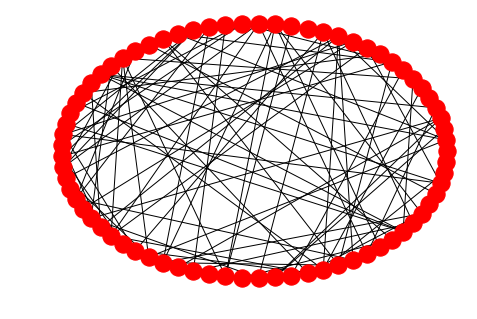

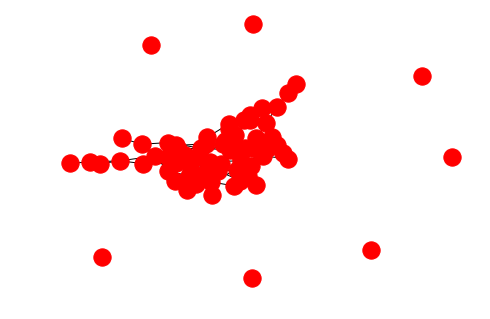

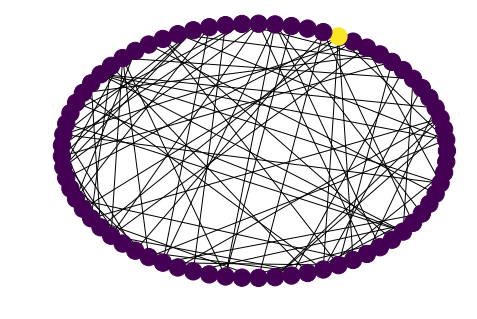

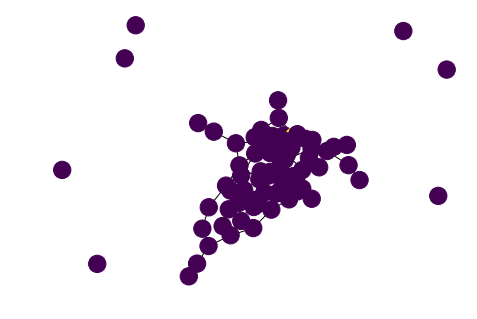

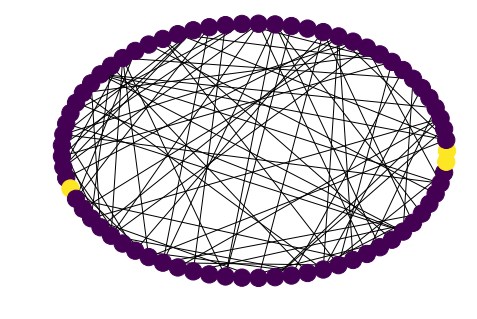

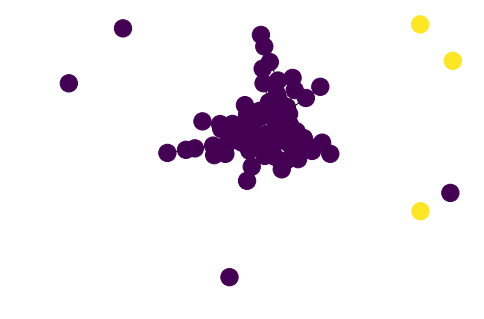

In [49]:
#reset_cmd_args()
model.eval()
index = np.random.choice(len(test_graphs))
batch_graph = [test_graphs[index]]
true_labels = [g.label for g in batch_graph]

node_feat, labels = myPrepareFeatureLabel(batch_graph)
embed,weights = myS2V_with_weight(model.s2v,batch_graph, node_feat, None)
logits, loss, acc =  model.mlp(embed, labels)
pred_label = torch.argmax(logits,dim=-1)
print(acc)

g = to_nx_graph(batch_graph[0])
print(true_labels,pred_label)

nx.draw(g,pos=nx.circular_layout(g))
plt.show()
nx.draw(g)
plt.show()
nx.draw(g,pos=nx.circular_layout(g),node_color=weights[0][0].detach().numpy())
plt.show()
nx.draw(g,node_color=weights[0][0].detach().numpy())
plt.show()
nx.draw(g,pos=nx.circular_layout(g),node_color=weights[1][0].detach().numpy())
plt.show()
nx.draw(g,node_color=weights[1][0].detach().numpy())
plt.show()

In [156]:
#reset_cmd_args()
model.eval()
for _ in range(300):
    index = np.random.choice(len(test_graphs))
    batch_graph = [test_graphs[index]]
    true_labels = [g.label for g in batch_graph]

    node_feat, labels = myPrepareFeatureLabel(batch_graph)
    embed,weights = myS2V_with_weight(model.s2v,batch_graph, node_feat, None)
    logits, loss, acc =  model.mlp(embed, labels)
    pred_label = torch.argmax(logits,dim=-1)
    print(acc)

    g = to_nx_graph(batch_graph[0])
    print(true_labels,pred_label)
    
    fig = plt.figure()
    nx.draw(g,pos=nx.circular_layout(g))
    plt.savefig('./visualize/pictures/%d-%d-1.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()
    
    fig = plt.figure()
    nx.draw(g)
    plt.savefig('./visualize/pictures/%d-%d-2.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()
    
    fig = plt.figure()
    nx.draw(g,pos=nx.circular_layout(g),node_color=weights[0][0].detach().numpy())
    plt.savefig('./visualize/pictures/%d-%d-3.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()
    
    fig = plt.figure()
    nx.draw(g,node_color=weights[0][0].detach().numpy())
    plt.savefig('./visualize/pictures/%d-%d-4.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()
    
    fig = plt.figure()
    nx.draw(g,pos=nx.circular_layout(g),node_color=weights[1][0].detach().numpy())
    plt.savefig('./visualize/pictures/%d-%d-5.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()
    
    fig = plt.figure()
    nx.draw(g,node_color=weights[1][0].detach().numpy())
    plt.savefig('./visualize/pictures/%d-%d-6.png'%(index,int(acc+0.5)))
    #plt.show()
    plt.close()

0.0
[7] tri_lattice turan
1.0
[6] tree tree
1.0
[3] cycle cycle
1.0
[4] hypercube hypercube
0.0
[6] tree circular_ladder
1.0
[1] circular_ladder circular_ladder
1.0
[2] complete complete
1.0
[2] complete complete
1.0
[1] circular_ladder circular_ladder
1.0
[8] turan turan
1.0
[1] circular_ladder circular_ladder
1.0
[5] shrinking_tree shrinking_tree
1.0
[6] tree tree
1.0
[8] turan turan
1.0
[2] complete complete
1.0
[0] barbell barbell
1.0
[6] tree tree
1.0
[5] shrinking_tree shrinking_tree
0.0
[7] tri_lattice turan
1.0
[0] barbell barbell
1.0
[3] cycle cycle
1.0
[0] barbell barbell
0.0
[7] tri_lattice turan
1.0
[6] tree tree
1.0
[0] barbell barbell
0.0
[6] tree barbell
1.0
[8] turan turan
1.0
[1] circular_ladder circular_ladder
1.0
[5] shrinking_tree shrinking_tree
1.0
[6] tree tree
1.0
[5] shrinking_tree shrinking_tree
1.0
[7] tri_lattice tri_lattice
1.0
[8] turan turan
1.0
[1] circular_ladder circular_ladder
1.0
[0] barbell barbell
0.0
[7] tri_lattice turan
1.0
[2] complete complete


In [99]:
len(weights),len(weights[0]),len(weights[0][0])

(2, 1, 26)